This notebook runs the state evolution equations for the different estimators. You need to compile the Rust library + the Python bindings before running it 

In [50]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy.integrate import quad
import scipy.stats as stats

from core.temperature_scaling import find_optimal_temperature_logit_teacher
from core.utility import probit, sigmoid_inv, KERNEL_COEFICIENTS, get_additional_noise_from_kappas
import core.utility as utility

import gcmpyo3
import experiments.search_lambda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# DEFINE THE PARAMETERS 

lambda_0 = 1e-4
beta_evidence = 1.0

# can be rho = 1.0
rho        = 1.0
n_over_d   = 2.0
noise_std  = 0.5
noise_var  = noise_std**2
activation = "erf"
data_model = "logit"

kappa0, kappa1, kappastar = utility.KERNEL_COEFICIENTS[activation]

In [52]:
# DEFINE THE STATE EVOLUTION PARAMS

erm_se_tolerance       = 1e-8
erm_relative_tolerance = False

pb_se_tolerance        = 1e-4
pb_relative_tolerance  = True

In [53]:
inv_alpha_range_for_lambda_0 = np.linspace(0.1, 5.0, 100)
alpha_range_for_lambda_0     = 1.0 / inv_alpha_range_for_lambda_0

In [54]:
# 1) Compute the overlaps for lambda = 0 and save them 

ms_for_lambda_0 = []
qs_for_lambda_0 = []
vs_for_lambda_0 = []
mhats_for_lambda_0 = []
qhats_for_lambda_0 = []
vhats_for_lambda_0 = []


for inv_alpha in tqdm.tqdm(inv_alpha_range_for_lambda_0):
    gamma = n_over_d * inv_alpha
    alpha = 1.0 / inv_alpha 
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_0, rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_lambda_0.append(m)
    qs_for_lambda_0.append(q)
    vs_for_lambda_0.append(v)
    mhats_for_lambda_0.append(mhat)
    qhats_for_lambda_0.append(qhat)
    vhats_for_lambda_0.append(vhat)


  7%|▋         | 7/100 [00:06<02:13,  1.44s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.000004848511052202298 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.023598627425791552 / 0.00000001, relative tol. is false


  9%|▉         | 9/100 [00:12<03:37,  2.39s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.07429798130195753 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.11931946673659954 / 0.00000001, relative tol. is false


 11%|█         | 11/100 [00:17<03:23,  2.28s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.010791043542526246 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.0012488812334732202 / 0.00000001, relative tol. is false


 13%|█▎        | 13/100 [00:21<03:07,  2.15s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.0002403356770486198 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.00004989225198581693 / 0.00000001, relative tol. is false


 15%|█▌        | 15/100 [00:25<02:53,  2.04s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.0000062958330593332335 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.0000012201259118604924 / 0.00000001, relative tol. is false


 17%|█▋        | 17/100 [00:28<02:40,  1.94s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.0000005998545562491131 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.00000020087610286267932 / 0.00000001, relative tol. is false


 19%|█▉        | 19/100 [00:32<02:28,  1.84s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.00000006088798931713768 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.00000001781315983606646 / 0.00000001, relative tol. is false


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


---

### Bayes optimal

In [55]:
alpha_range_for_bayes_optimal = np.array(alpha_range_for_lambda_0)
inv_alpha_range_for_bayes_optimal = 1.0 / alpha_range_for_bayes_optimal

In [56]:

# 1) Compute the overlaps for lambda = 0 and save them 

ms_for_bayes_optimal = []
qs_for_bayes_optimal = []
vs_for_bayes_optimal = []
mhats_for_bayes_optimal = []
qhats_for_bayes_optimal = []
vhats_for_bayes_optimal = []


for alpha in tqdm.tqdm(alpha_range_for_bayes_optimal):
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.bayes_optimal_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, rho, data_model, 1e-6, False, False)
    ms_for_bayes_optimal.append(m)
    qs_for_bayes_optimal.append(q)
    vs_for_bayes_optimal.append(v)
    mhats_for_bayes_optimal.append(mhat)
    qhats_for_bayes_optimal.append(qhat)
    vhats_for_bayes_optimal.append(vhat)

100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


In [57]:
exp_inv_alpha_range_for_bayes_optimal = []
exp_ms_for_bayes_optimal = []
exp_qs_for_bayes_optimal = []
exp_vs_for_bayes_optimal = []
exp_mhats_for_bayes_optimal = []
exp_qhats_for_bayes_optimal = []
exp_vhats_for_bayes_optimal = []

*Bayes optimal on the teacher's data*

In [58]:
# In the matched case + logit data, pseudo bayes with beta = corresponding to the noise, lambda = 1.0 / rho <=> Bayes optimal
m_bo, q_bo, v_bo, mhat_bo, qhat_bo, vhat_bo = gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(n_over_d, noise_var, rho, data_model, pb_se_tolerance, pb_relative_tolerance, verbose = False)

---

### Empirical bayes : evidence maximization

In [59]:
inv_alpha_range_for_lambda_evidence = inv_alpha_range_for_lambda_0
alpha_range_for_lambda_evidence = 1.0 / inv_alpha_range_for_lambda_evidence

lambda_evidence = [ experiments.search_lambda.empirical_bayes_compute_optimal_lambda_for_evidence(1.0 / inv_alpha, inv_alpha * n_over_d, noise_std, False, activation) for inv_alpha in tqdm.tqdm(inv_alpha_range_for_lambda_evidence) ]

100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


In [60]:
ms_for_lambda_evidence = []
qs_for_lambda_evidence = []
vs_for_lambda_evidence = []

mhats_for_lambda_evidence = []
qhats_for_lambda_evidence = []
vhats_for_lambda_evidence = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_lambda_evidence)):
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, beta_evidence, noise_var, gamma, kappa1, kappastar, lambda_evidence[i], rho, data_model, pb_se_tolerance, pb_relative_tolerance, normalized = True, verbose = False)
    ms_for_lambda_evidence.append(m)
    qs_for_lambda_evidence.append(q)
    vs_for_lambda_evidence.append(v)
    mhats_for_lambda_evidence.append(mhat)
    qhats_for_lambda_evidence.append(qhat)
    vhats_for_lambda_evidence.append(vhat)

100it [00:11,  8.81it/s]


---

### Empirical Bayes : error cross-validation

In [61]:
inv_alpha_range_for_pb_lambda_error = inv_alpha_range_for_lambda_0
alpha_range_for_pb_lambda_error = 1.0 / inv_alpha_range_for_pb_lambda_error

pb_lambda_error = [ experiments.search_lambda.empirical_bayes_compute_optimal_lambda_for_error(1.0 / inv_alpha, inv_alpha * n_over_d, noise_std, False, activation) for inv_alpha in tqdm.tqdm(inv_alpha_range_for_pb_lambda_error) ]

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


In [62]:
ms_for_pb_lambda_error = []
qs_for_pb_lambda_error = []
vs_for_pb_lambda_error = []

mhats_for_pb_lambda_error = []
qhats_for_pb_lambda_error = []
vhats_for_pb_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_pb_lambda_error)):
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, beta_evidence, noise_var, gamma, kappa1, kappastar, pb_lambda_error[i], rho, data_model, pb_se_tolerance, pb_relative_tolerance, normalized = True, verbose = False)
    ms_for_pb_lambda_error.append(m)
    qs_for_pb_lambda_error.append(q)
    vs_for_pb_lambda_error.append(v)
    mhats_for_pb_lambda_error.append(mhat)
    qhats_for_pb_lambda_error.append(qhat)
    vhats_for_pb_lambda_error.append(vhat)

100it [00:13,  7.59it/s]


---

### ERM lambda error

In [63]:
inv_alpha_range_for_erm_lambda_error = inv_alpha_range_for_lambda_0
alpha_range_for_erm_lambda_error = 1.0 / inv_alpha_range_for_erm_lambda_error

erm_lambda_error = [ experiments.search_lambda.erm_compute_optimal_lambda_for_error(1.0 / inv_alpha , noise_std, n_over_d * inv_alpha, activation, 1e-3, 10.0, 1e-4, False, rho) for inv_alpha in tqdm.tqdm(inv_alpha_range_for_erm_lambda_error) ]

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


In [64]:
ms_for_erm_lambda_error = []
qs_for_erm_lambda_error = []
vs_for_erm_lambda_error = []

mhats_for_erm_lambda_error = []
qhats_for_erm_lambda_error = []
vhats_for_erm_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_error)):
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, erm_lambda_error[i], rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_erm_lambda_error.append(m)
    qs_for_erm_lambda_error.append(q)
    vs_for_erm_lambda_error.append(v)
    mhats_for_erm_lambda_error.append(mhat)
    qhats_for_erm_lambda_error.append(qhat)
    vhats_for_erm_lambda_error.append(vhat)

100it [00:06, 14.51it/s]


--- 

### ERM lambda loss

In [68]:
inv_alpha_range_for_erm_lambda_loss = inv_alpha_range_for_lambda_0
alpha_range_for_erm_lambda_loss = 1.0 / inv_alpha_range_for_erm_lambda_loss

erm_lambda_loss = [ experiments.search_lambda.erm_compute_optimal_lambda_for_loss(1.0 / inv_alpha , noise_std, n_over_d * inv_alpha, activation, 1e-3, 10.0, 1e-4, False, rho) for inv_alpha in tqdm.tqdm(inv_alpha_range_for_erm_lambda_loss) ]




  0%|          | 0/100 [00:00<?, ?it/s]









































































































































































































100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [69]:
ms_for_erm_lambda_loss = []
qs_for_erm_lambda_loss = []
vs_for_erm_lambda_loss = []

mhats_for_erm_lambda_loss = []
qhats_for_erm_lambda_loss = []
vhats_for_erm_lambda_loss = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_loss)):
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, erm_lambda_loss[i], rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_erm_lambda_loss.append(m)
    qs_for_erm_lambda_loss.append(q)
    vs_for_erm_lambda_loss.append(v)
    mhats_for_erm_lambda_loss.append(mhat)
    qhats_for_erm_lambda_loss.append(qhat)
    vhats_for_erm_lambda_loss.append(vhat)




0it [00:00, ?it/s]



































































100it [00:04, 22.18it/s]


---

### Compare the test errors

In [70]:
error_lambda_0        = [utility.generalisation_error_logit_teacher(rho, m, q,noise_std) for m, q in zip(ms_for_lambda_0, qs_for_lambda_0)]
error_bayes_optimal   = [utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_bayes_optimal, qs_for_bayes_optimal)]
error_lambda_evidence = [utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_lambda_evidence, qs_for_lambda_evidence)]
error_pb_lambda_error = [utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error)]
error_erm_lambda_error = [utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error)]
error_erm_lambda_loss = [utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss)]

In [71]:
error_matched_bayes_optimal = utility.generalisation_error_logit_teacher(rho, m_bo, q_bo, noise_std)
error_teacher               = utility.generalisation_error_logit_teacher(rho, rho, rho, noise_std)

Text(0, 0.5, '$\\varepsilon_g$')

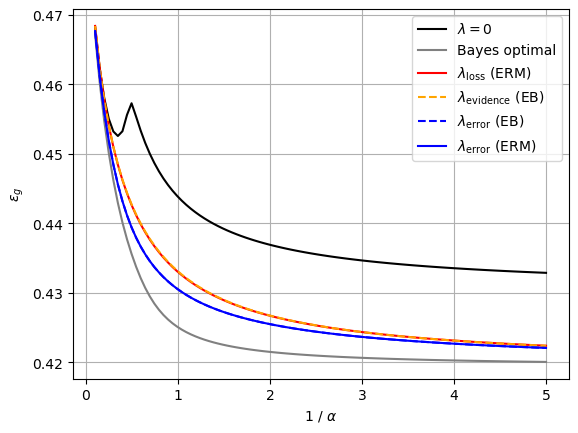

In [73]:
plt.plot(inv_alpha_range_for_lambda_0, error_lambda_0, label='$\\lambda = 0$', c = 'k')
plt.plot(inv_alpha_range_for_bayes_optimal, error_bayes_optimal, label='Bayes optimal', c = 'gray')
plt.plot(inv_alpha_range_for_erm_lambda_loss, error_erm_lambda_loss, 'r', label='$\\lambda_{\\rm loss}$ (ERM)')
plt.plot(inv_alpha_range_for_lambda_evidence, error_lambda_evidence, '--', label='$\\lambda_{\\rm evidence}$ (EB)', c = 'orange')
plt.plot(inv_alpha_range_for_pb_lambda_error, error_pb_lambda_error, 'b--', label='$\\lambda_{\\rm error}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_error, error_erm_lambda_error, 'b', label='$\\lambda_{\\rm error}$ (ERM)')
plt.legend()
plt.grid()

plt.xlabel('1 / $ \\alpha $')
plt.ylabel('$\\varepsilon_g$')

---

### Calibration

In [74]:
level = 0.75
add_vars_bayes_optimal = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_bayes_optimal]
add_vars_evidence = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_lambda_evidence]
add_vars_eb_error = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_pb_lambda_error]
add_vars_error    = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_erm_lambda_error]
add_vars_loss     = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_erm_lambda_loss]
add_vars_0        = [utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_d * inv_alpha) for inv_alpha in inv_alpha_range_for_lambda_0]


In [75]:
# Compute the noise variance for Laplace 

variance_laplace_lambda_0     = [ utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_d * inv_alpha, 1e-4, vhat) for inv_alpha, vhat in zip(inv_alpha_range_for_lambda_0, vhats_for_lambda_0) ]
variance_laplace_lambda_error = [ utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_d * inv_alpha, lambda_, vhat) for inv_alpha, lambda_, vhat in zip(inv_alpha_range_for_erm_lambda_error, erm_lambda_error, vhats_for_erm_lambda_error) ]
variance_laplace_lambda_loss  = [ utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_d * inv_alpha, lambda_, vhat) for inv_alpha, lambda_, vhat in zip(inv_alpha_range_for_erm_lambda_loss, erm_lambda_loss, vhats_for_erm_lambda_loss) ]


In [76]:
# NOTE : small difference w/ and w/o the additional noise, prolly due to the probit approximation
level = 0.75

calibration_lambda_0      = [ utility.calibration_logit_teacher(level, m ,q, rho - add_var, 0.0, noise_var + add_var) for m, q, add_var in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, add_vars_0))]
calibration_lambda_evidence = [utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence))]
calibration_pb_lambda_error = [utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error, vs_for_pb_lambda_error))]
calibration_erm_lambda_error= [utility.calibration_logit_teacher(level, m ,q, rho, 0.0, noise_var) for m, q in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error))]
calibration_erm_lambda_loss = [utility.calibration_logit_teacher(level, m ,q, rho, 0.0, noise_var) for m, q in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss))]



100it [00:00, 162067.39it/s]



0it [00:00, ?it/s]

100it [00:00, 18057.10it/s]


100it [00:00, 19696.19it/s]


100it [00:00, 196915.68it/s]


100it [00:00, 183799.47it/s]


In [77]:
calibration_laplace_lambda_error = [utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, variance_laplace_lambda_error))]
calibration_laplace_lambda_loss  = [utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, variance_laplace_lambda_loss))]
calibration_laplace_lambda_0     = [utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, variance_laplace_lambda_0))]



100it [00:00, 23854.31it/s]




100it [00:00, 24436.63it/s]


100it [00:00, 9672.10it/s]


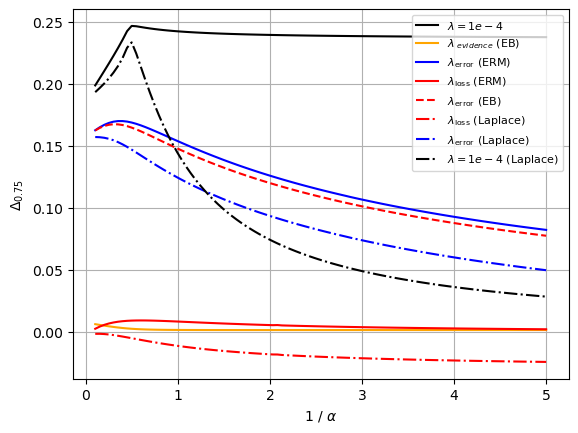

In [78]:
plt.plot(inv_alpha_range_for_lambda_0, calibration_lambda_0, 'k', label='$\\lambda = 1e-4$')
plt.plot(inv_alpha_range_for_lambda_evidence, calibration_lambda_evidence, c = 'orange', label='$\\lambda_{\\ evidence}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_erm_lambda_error, c = 'b', label='$\\lambda_{\\rm error}$ (ERM)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_erm_lambda_loss, c = 'r', label='$\\lambda_{\\rm loss}$ (ERM)')
plt.plot(inv_alpha_range_for_pb_lambda_error, calibration_pb_lambda_error, 'r--', label='$\\lambda_{\\rm error}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_laplace_lambda_loss, 'r-.', label='$\\lambda_{\\rm loss}$ (Laplace)')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_laplace_lambda_error, 'b-.', label='$\\lambda_{\\rm error}$ (Laplace)')
plt.plot(inv_alpha_range_for_lambda_0, calibration_laplace_lambda_0, 'k-.', label='$\\lambda = 1e-4$ (Laplace)')

plt.legend()
plt.grid()

plt.xlabel('1 / $\\alpha$')
plt.ylabel('$\\Delta_{' + str(level) + '}$')

plt.legend(prop={'size': 8})

---

# Conditional variance


In [79]:
# Conditional variance of the Bayes Optimal

bayes_optimal_cond_variance_lambda_0        = [utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo, vbo, add_var in zip(ms_for_lambda_0, qs_for_lambda_0, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_0)]
bayes_optimal_cond_variance_lambda_error    = [utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_error)]
bayes_optimal_cond_variance_eb_lambda_error = [utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_eb_error)]
bayes_optimal_cond_variance_lambda_loss     = [utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_loss)]
bayes_optimal_cond_variance_lambda_evidence = [utility.conditional_variance_logit_teacher(level, m, q, qbo, v, vbo + noise_var + add_var) for m, q, v, qbo, vbo,  add_var in zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence, qs_for_bayes_optimal,  vs_for_bayes_optimal, add_vars_evidence)]

  0%|          | 0/100 [03:54<?, ?it/s]


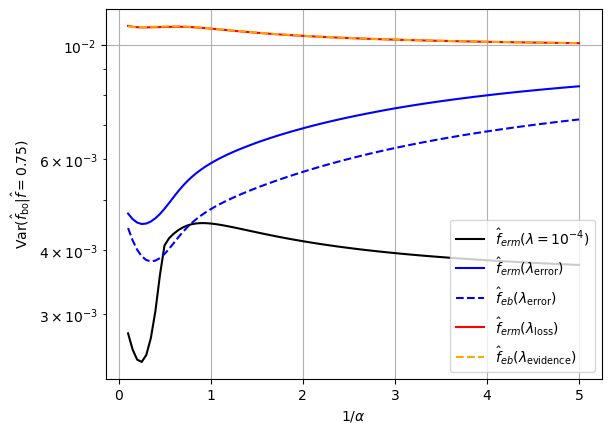

In [80]:
plt.plot(inv_alpha_range_for_lambda_0, bayes_optimal_cond_variance_lambda_0, c='k', label='$\\hat{f}_{erm}(\\lambda = 10^{-4})$')
plt.plot(inv_alpha_range_for_erm_lambda_error, bayes_optimal_cond_variance_lambda_error, c='b', label='$\\hat{f}_{erm}(\\lambda_{\\rm error})$')
plt.plot(inv_alpha_range_for_pb_lambda_error, bayes_optimal_cond_variance_eb_lambda_error, 'b--', label='$\\hat{f}_{eb}(\\lambda_{\\rm error})$')
plt.plot(inv_alpha_range_for_erm_lambda_loss, bayes_optimal_cond_variance_lambda_loss, 'r', label='$\\hat{f}_{erm}(\\lambda_{\\rm loss})$')
plt.plot(inv_alpha_range_for_lambda_evidence, bayes_optimal_cond_variance_lambda_evidence, '--', c='orange', label='$\\hat{f}_{eb}(\\lambda_{\\rm evidence})$')

plt.xlabel('$1 / \\alpha$')
plt.ylabel('${\\rm Var}(\\hat{f}_{\\rm bo} | \\hat{f} = ' + str(level) + ')$')

plt.yscale("log")

plt.grid()
plt.legend()

---

# Temperature scaling

In [81]:
# for lambda = 0

temps_opts_lambda_0 = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_lambda_0)):
    m, q = ms_for_lambda_0[i], qs_for_lambda_0[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_0.append(temp_opt)

100it [00:16,  6.24it/s]


In [82]:
# for lambda = error

temps_opts_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_error)):
    m, q = ms_for_erm_lambda_error[i], qs_for_erm_lambda_error[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_error.append(temp_opt)

100it [00:19,  5.01it/s]


In [83]:
# for lambda_loss

temps_opts_lambda_loss = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_loss)):
    m, q = ms_for_erm_lambda_loss[i], qs_for_erm_lambda_loss[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_loss.append(temp_opt)

100it [00:21,  4.75it/s]


--

In [84]:
# Compute the calibration after temperature scaling

level = 0.75

calibration_with_temp_scaling_lambda_0      = [ utility.calibration_logit_teacher(level,  m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, temps_opts_lambda_0))]
calibration_with_temp_scaling_erm_lambda_error= [utility.calibration_logit_teacher(level, m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, temps_opts_lambda_error))]
calibration_with_temp_scaling_erm_lambda_loss = [utility.calibration_logit_teacher(level, m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, temps_opts_lambda_loss))]
calibration_lambda_evidence = [utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence))]

100it [00:00, 190910.51it/s]
100it [00:00, 153637.51it/s]
100it [00:00, 217321.45it/s]
100it [00:00, 25177.41it/s]


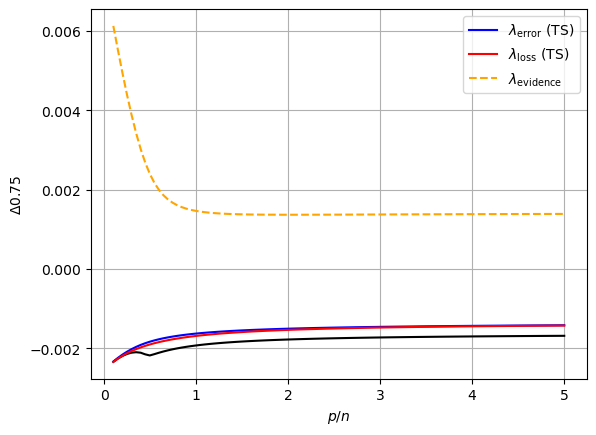

In [85]:
plt.plot(inv_alpha_range_for_lambda_0, calibration_with_temp_scaling_lambda_0, c='k')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_with_temp_scaling_erm_lambda_error, 'b', label='$\\lambda_{\\rm error}$ (TS)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_with_temp_scaling_erm_lambda_loss, 'r', label='$\\lambda_{\\rm loss}$ (TS)')
plt.plot(inv_alpha_range_for_lambda_evidence, calibration_lambda_evidence, '--', c='orange', label='$\\lambda_{\\rm evidence}$')

plt.xlabel('$p/n$')
plt.ylabel(f'$\\Delta${level}')

plt.grid()
plt.legend()

--

In [48]:
# Compute the conditional variance after temperature scaling

level = 0.75 
bo_cond_variance_temp_scaling_error = [utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, temps_opts_lambda_error, add_vars_error, qs_for_bayes_optimal, vs_for_bayes_optimal)]
bo_cond_variance_temp_scaling_loss  = [utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_erm_lambda_loss , qs_for_erm_lambda_loss , temps_opts_lambda_loss , add_vars_loss , qs_for_bayes_optimal, vs_for_bayes_optimal)]
bo_cond_variance_temp_scaling_0     = [utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_lambda_0 , qs_for_lambda_0 , temps_opts_lambda_0 , add_vars_0 , qs_for_bayes_optimal, vs_for_bayes_optimal)]

Text(0, 0.5, 'Var($\\hat{f}_{\\rm bo} | \\hat{f}_{\\rm erm} = 0.75$)')

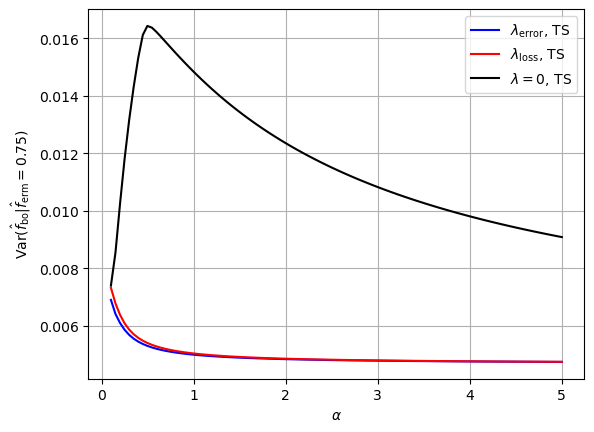

In [49]:
plt.plot(inv_alpha_range_for_erm_lambda_error, bo_cond_variance_temp_scaling_error, 'b', label='$\\lambda_{\\rm error}$, TS')
plt.plot(inv_alpha_range_for_erm_lambda_loss, bo_cond_variance_temp_scaling_loss, 'r', label='$\\lambda_{\\rm loss}$, TS')
plt.plot(inv_alpha_range_for_lambda_0, bo_cond_variance_temp_scaling_0, 'k', label='$\\lambda = 0$, TS')

plt.grid()
plt.legend()
 
plt.xlabel('$\\alpha$')
plt.ylabel('Var($\\hat{f}_{\\rm bo} | \\hat{f}_{\\rm erm} = 0.75$)')